In [26]:
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, sosfilt
import numpy as np

cell_number = 10 #pfc_clusters is made later on which each cluster/putative neuron number in the pfc
tetrode_number = 17 #Can check in google sheets which tetrodes work based on training day, usually 17-32 is fine
    #For JC315, tetrode 17 is in the HPC pyrimidale every day
    #JC283 varies a lot more and doesn't always have pyramidale
        #20230930 [25,27, 30, 21] are pyramidale; 
        #20231001 and 02 [26, 30] are oriens/sup. pyramidale; 
        #20231003 [17, 19, 25] in pyramidale

clu_res_filepath = 'JC315-20240408/JC315-20240408_training1' #don't include .clu or .res here

eegh_filepath = 'JC315-eegh/20240408/JC315-20240408_02.eegh'
eeg_fs = 5000 #5 kHz sampling frequency for eegh, or 1.25 kHz for eeg

speed_filepath = 'eight_arm_fig_data_andrea/analysis/JC315-20240408/JC315_20240408_training1.speed'
des_filepath = 'JC315-20240408/JC315-20240408.des'

In [27]:
'''Import spikes'''
#Import .res and .clu (code from Cell_map.ipynb)
def to_int_list(filename):
    file = open(filename)
    file_list = file.readlines()
    file.close()
    for i in range(len(file_list)):
        file_list[i] = int(file_list[i].strip('\n'))
    return file_list

#.clu file is the cluster ID (putative neuron ID) for the corresponding .res file spikes
clu = to_int_list(clu_res_filepath + '.clu')[1:]#Removing the first (noise) cluster
#.res file is the "frame" at sampling frequency 20kHz in which spikes occur
res = to_int_list(clu_res_filepath + '.res')

In [28]:
'''Import .speed, filter only for speeds above threshold'''
#Threshold = 7cm/s for Nardin, or 5cm/s for Vlad's github

#Import .speed, which has the same length as the .whl file and recorded at 39.0625 Hz (so you can multiply it by 512 to get to 20 kHz)
file = open(speed_filepath) #Different than to_int_list() above because these are float values
speed = file.readlines()
file.close()
for i in range(len(speed)):
    speed[i] = float(speed[i].strip('\n'))


spike_index = [i for i, x in enumerate(clu) if x == cell_number] #since clu and res have corresponding indices
all_spikes = [res[i] for i in spike_index] #in frame number of the spike recording, in 20kHz
spike_frame = [i for i in all_spikes if abs(speed[round(i / 512)]) >= 5] #if the speed during a spike is 5cm/s or above, the spike is kept

print('num spikes = ', len(all_spikes),
      '\nnum spikes above 5 cm/s = ', len(spike_frame))
#Could choose here to exclude cells that average less than 0.25 spikes/second, as in Nardin et al., 2023

num spikes =  5173 
num spikes above 5 cm/s =  1481


In [29]:
'''Import des to determine the identity of clusters'''
file = open(des_filepath)
des_raw = file.readlines()
file.close()
des = [i.strip('\n') for i in des_raw]
#The value given in clu is described by des[value - 2] since cluster 1 is noise

pfc_clusters = [i + 2 for i, x in enumerate(des) if x[1] == 'p'] #selects all clusters in the pfc (when the 2nd value in the des line is 'p')
    #This includes putative pyramidal (first value is 'p') and putative interneuron/basket (first value is 'b')

In [30]:
'''Import eegh, determine spike phases'''
eeg = np.fromfile(eegh_filepath, dtype = np.uint16)
one_channel = eeg[int(tetrode_number*len(eeg)/32) : int((tetrode_number+1)*len(eeg)/32)]; #Assuming that there are always 32 channels


#calculate inst_phase for the entire eegh recording
sos = butter(3, [5, 12], btype = 'bandpass', output = 'sos', analog = False, fs = eeg_fs)
filtered = sosfilt(sos, one_channel)

# t = np.arange(len(subsample)) / fs  #Creating time axis if you want to plot signal vs. time


analytic_signal = hilbert(filtered) #Where filtered is a ~1s portion of the theta band-pass filtered EEG
amplitude_envelope = np.abs(analytic_signal)
inst_phase = np.unwrap(np.angle(analytic_signal))
inst_freq = (np.diff(inst_phase) / 
             (2.0 * np.pi) * eeg_fs)

spike_phase = [inst_freq[round(i / 4)] for i in spike_frame] #inst theta phase of the eeg during each spike
spike_time = [i / 20_000 for i in spike_frame] #time [s] of each spike, only necessary to plot polar w/ radius = time

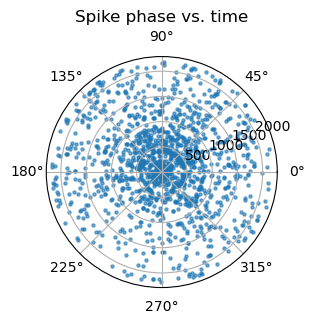

In [31]:
#Graph spike_phase as theta and spike_time as r in polar coordinates
fig, ax = plt.subplots(subplot_kw = {'projection': 'polar'}, figsize = (3, 3))
ax.scatter(spike_phase, spike_time, s = 5, alpha = 0.6)
ax.set_rticks([500, 1000, 1500, 2000]) #Set radial ticks (in seconds)
ax.grid(True)
ax.set_title('Spike phase vs. time')
plt.show()

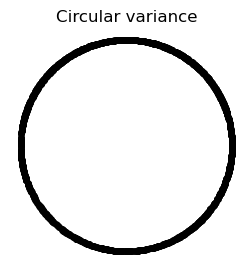

In [32]:
#also graph spikes in a circle, as seen in scipy.stats.circvar()
fig, ax = plt.subplots(figsize = (3, 3))
ax.plot(np.cos(np.linspace(0, 2*np.pi, 500)),
           np.sin(np.linspace(0, 2*np.pi, 500)),
           c='k')
ax.axis('equal')
ax.axis('off')
ax.scatter(np.cos(spike_phase), np.sin(spike_phase), c='k', s=15)
ax.set_title('Circular variance') #Can also add the value in here
plt.show()


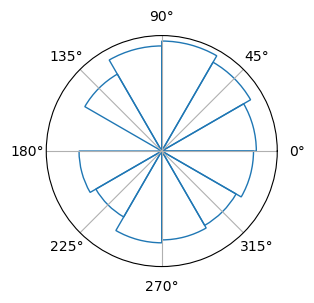

In [154]:
'''Make a circular histogram'''
#Modified from circular_hist() in https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python
#Using 12 bins, as with figure 3A in Nardin et al., 2023

# wrapped_angles = [i % (2*np.pi) for i in spike_phase] #Wrap angles such that they are all in [0, 2pi) 
wrapped_angles = [(i + np.pi) % (2*np.pi) - np.pi for i in spike_phase]
#can now make a cartesian hist with plt.hist(wrapped_angles, bins = 12)
   # x = (x+np.pi) % (2*np.pi) - np.pi

#Bin the angles
# n, bins = np.histogram(wrapped_angles, bins=12) 
bins = np.linspace(-np.pi, (5/12) * 2 * np.pi, 12)
# print(bins)

n = []
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0]
for i in range(len(indices) - 1):
    start_angle = bins[indices[int(i)]]
    end_angle = bins[indices[int(i) + 1]]
    count = len([i for i in wrapped_angles if start_angle <= i < end_angle])
    n.append(count)

# print(n)

# print(len(wrapped_angles))
# print(wrapped_angles)

# print(bins[-1])
# Compute width of each bin
widths = np.diff(bins) #np.diff() calculates the nth discrete difference (?)

#Can either plot so that the amt in each bin corresponds to the area OR the radius of each pie slice, I chose are
area = []
radius = []

for i in range(len(n)):
    area.append(n[i] / len(wrapped_angles)) # Area to assign each bin

for i in range(len(n)):
    radius.append((area[i]/np.pi) ** .5) # Calculate corresponding bin radius

# print(radius)

fig, ax = plt.subplots(subplot_kw = {'projection': 'polar'}, figsize = (3, 3))
ax.set_yticks([])
ax.bar(bins, radius, zorder=1,  align='edge',
                     edgecolor='C0', fill=False, linewidth=1, width = (2 * np.pi) / 12) #width=widths
# print(bins)
plt.show()

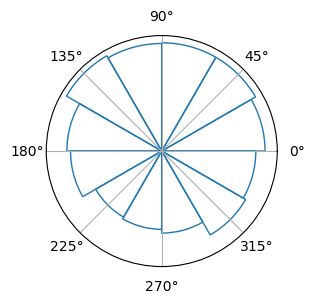

In [33]:
'''Make a circular histogram'''
#Modified from circular_hist() in https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python

num_bins = 12 #Using 12 bins, as with figure 3A in Nardin et al., 2023


wrapped_angles = [(i + np.pi) % (2*np.pi) - np.pi for i in spike_phase]
#can now make a cartesian hist with plt.hist(wrapped_angles, bins = 12)

#Bin the angles
bins = np.linspace(-np.pi, np.pi, num_bins + 1)

n = []
for i in range(num_bins):
    start_angle = bins[i]
    end_angle = bins[i + 1]
    count = len([i for i in wrapped_angles if start_angle <= i < end_angle])
    n.append(count)


#Can either plot so that the amt in each bin corresponds to the area OR the radius of each pie slice, I chose area.
area = [i / len(wrapped_angles) for i in n]
radius = [(i / np.pi)**0.5 for i in area]

#Plot
fig, ax = plt.subplots(subplot_kw = {'projection': 'polar'}, figsize = (3, 3))
ax.set_yticks([])
ax.bar(bins[:-1], radius, zorder=1,  align='edge',
                     edgecolor='C0', fill=False, linewidth=1, width = (2 * np.pi) / num_bins) #width=widths
# print(bins)
plt.show()

In [ ]:
'''Calculate statistics for directional selectivity and its significance'''

#

In [70]:
##
#Find the mean direction vector and the mean resultant length of all of these values for the given cell (also a p value?)

from scipy.stats import circmean, circvar, rayleigh
    #directional_stats, rayleigh

# #Turn spike_phase into unit vectors
# test = spike_phase[:10]
# test = np.array(test)
# print(test)

# print(test.reshape(-1, 1))
# print(min(spike_phase))

# print(sorted(spike_phase)[-10:])

#First, use directional stats to determine the directional mean and the mean resultant length
    #Or possibly just circmean and circvar from scipy.stats? Circvar there is 1 - mean resultant length

# result = rayleigh(spike_phase)
# p_value = result.pvalue

# print(p_value)

# phases_array = np.array(spike_phase)
# phases_array.reshape(-1, 1)


# print(phases_array[:10])
# res = directional_stats(phases_array, axis = 0, normalize = False)
# print('mean direction:', res.mean_direction)

print('directional mean:', circmean(spike_phase))
print('mean resultant length:', 1 - circvar(spike_phase))

# result = rayleigh(spike_phase)
# p_value = result.pvalue


# r, p_value = rayleigh.test(spike_phase)
# print(p_value)

mean, var, skew, kurt = rayleigh.stats(moments = 'mvsk')
print('mean =', mean)
print('var =', var)

# fig, ax = plt.subplots(1,1)
# x = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 100)
# ax.plot(x, rayleigh.pdf(x),
        # 'r-', lw = 5, alpha = 0.6, label = 'rayleigh pdf')

# ax.plot(spike_phase, rayleigh.pdf(spike_phase),
#         'r-', lw = 5, alpha = 0.6, label = 'rayleigh pdf')


test_stat = len(spike_phase) * (1 - circvar(spike_phase))**2
    #Described in Mardia, Jupp (2000) textbook, the Rayleigh test stat is 2*n*R_bar**2, where R_bar is the mean resultant length 
print('rayleigh test stat =', test_stat)

directional mean: 6.27783270374459
mean resultant length: 0.05583636337950926
mean = 1.2533141373155001
var = 0.42920367320510344
rayleigh test stat = 0.1247079790179441


In [ ]:
#Rayleigh stats mean = 1.2533
#Rayleigh stats variance = 0.429
#Directional mean (circmean(spike_phase)) = 1.3567
#Mean resultant length (1 - circvar(spike_phase)) = 0.2640